# Expected Return Modeling

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
folder_path = "data"
stack_name = os.path.join(folder_path, "data_stack.h5")
adjp_name = os.path.join(folder_path, "data_adjp.h5")

df_stack = pd.read_hdf(stack_name)
df_adjp = pd.read_hdf(adjp_name)

In [3]:
is_ratio = 0.7
isos_split = df_stack.index[int(len(df_stack)*is_ratio)][0]
df_stack_is = df_stack[df_stack.index.get_level_values(0)<isos_split]
df_stack_os = df_stack[df_stack.index.get_level_values(0)>=isos_split]

model_folder = "model"

is_name = os.path.join(model_folder, "df_is.h5")
df_stack_is.to_hdf(is_name, key='df', mode='w')
os_name = os.path.join(model_folder, "df_os.h5")
df_stack_os.to_hdf(os_name, key='df', mode='w')

df_stack_is_c = df_stack_is.copy()
df_stack_os_c = df_stack_os.copy()

In [4]:
features = list(df_stack_is_c.columns)[:-1]
target = list(df_stack_is_c.columns)[-1]

In [5]:
cv_scores = []

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9],
}

for train_index, test_index in tscv.split(df_stack_is_c):
    # update train test index for time series consistency
    dt_series = df_stack_is_c.reset_index()['Date']
    old_split = int(train_index[-1])
    old_end = int(test_index[-1])
    split_dt = dt_series.iloc[old_split]
    new_split = dt_series[dt_series<=split_dt].index[-1] + 1
    train_index = np.arange(0, new_split, dtype=np.int32)
    test_index = np.arange(new_split, old_end+1, dtype=np.int32)
    
    train_data = df_stack_is_c.iloc[train_index]
    test_data = df_stack_is_c.iloc[test_index]
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    # more sample weight to recent data
    sample_weights = dt_series.iloc[train_index].rank(method='min')
    sample_weights = sample_weights.to_numpy()
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)
    
    best_params = grid_search.best_params_
    
    xgb_model = xgb.XGBRegressor(**best_params)
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred = xgb_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_scores.append(rmse)

average_rmse = np.mean(cv_scores)
print(f'Average RMSE: {average_rmse:.4f}')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Average RMSE: 0.0786


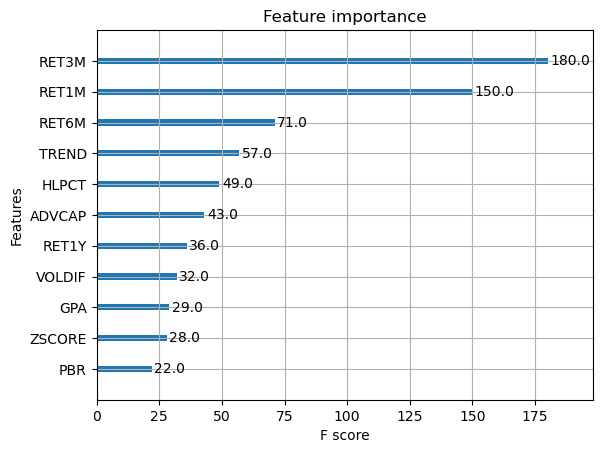

In [6]:
importance_name = os.path.join(model_folder, "importance.jpg")
fig1, ax1 = plt.subplots()
xgb.plot_importance(xgb_model, ax=ax1)
fig1.figure.savefig(importance_name, dpi=150, bbox_inches='tight')

In [7]:
x_is = df_stack_is_c[features]
y_is = df_stack_is_c[target]
y_is_predict = xgb_model.predict(x_is)

x_os = df_stack_os_c[features]
y_os = df_stack_os_c[target]
y_os_predict = xgb_model.predict(x_os)

os_rmse = np.sqrt(mean_squared_error(y_os, y_os_predict))
print(f'Average RMSE: {os_rmse:.4f}')

Average RMSE: 0.0826


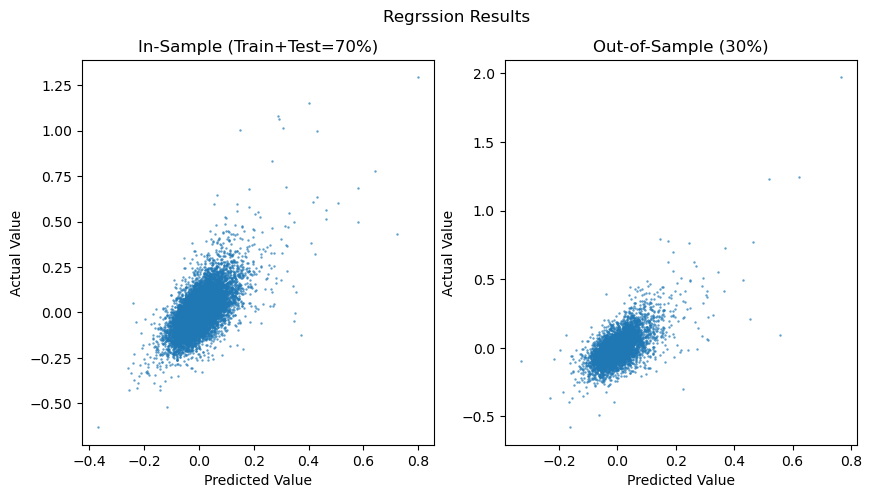

In [8]:
regression_name = os.path.join(model_folder, "regression.jpg")

fig2, ax2 = plt.subplots(1,2, figsize=(10,5))
fig2.suptitle("Regrssion Results")

sns.scatterplot(x=y_is_predict, y=y_is, ax=ax2[0], s=3, linewidth=0, alpha=0.7)
sns.scatterplot(x=y_os_predict, y=y_os, ax=ax2[1], s=3, linewidth=0, alpha=0.7)

ax2[0].set_title("In-Sample (Train+Test=70%)")
ax2[1].set_title("Out-of-Sample (30%)")
ax2[0].set_xlabel("Predicted Value")
ax2[0].set_ylabel("Actual Value")
ax2[1].set_xlabel("Predicted Value")
ax2[1].set_ylabel("Actual Value")

fig2.figure.savefig(regression_name, dpi=150, bbox_inches='tight')

In [9]:
model_name = os.path.join(model_folder, "xgb.json")
xgb_model.save_model(model_name)